# Benchmarking Results

In [1]:
import numpy as np
import notebook_helper_functions.plot_functions as plot_funcs

### 1. Baseline execute time

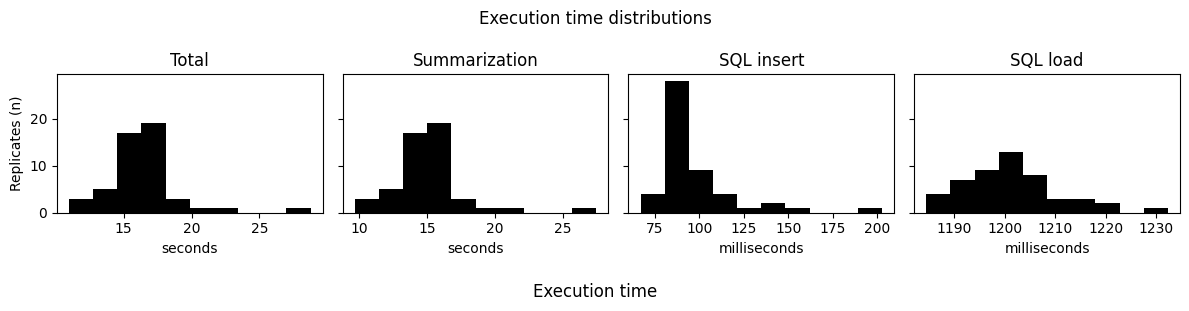

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,3,65.672780,61.801335,0.268359,3.603086,21.890927,20.600445,0.089453,1.201029
1,2,3,51.169636,47.098700,0.472522,3.598414,17.056545,15.699567,0.157507,1.199471
2,3,3,51.191517,47.301782,0.284421,3.605313,17.063839,15.767261,0.094807,1.201771
3,4,3,48.681545,44.815677,0.247361,3.618507,16.227182,14.938559,0.082454,1.206169
4,5,3,50.179890,46.316243,0.259831,3.603815,16.726630,15.438748,0.086610,1.201272


In [2]:
data, plt = plot_funcs.baseline_execution_plot('../benchmarks/baseline_execute_time/results.csv')

plt.show()
data.head()


### 2. Huggingface device map

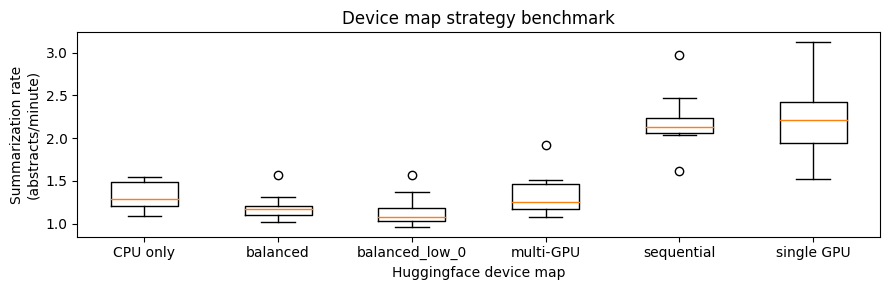

,replicate,abstracts,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,3,CPU only,48.627154,0.020565,1.233879
1,2,3,CPU only,44.645400,0.022399,1.343923
2,3,3,CPU only,49.478651,0.020211,1.212644
3,4,3,CPU only,49.861394,0.020056,1.203336
4,5,3,CPU only,39.092824,0.025580,1.534809


In [3]:
data, plt = plot_funcs.device_map_plot('../benchmarks/huggingface_device_map/results.csv')

plt.show()
data.head()

### 3. Parallel summarization

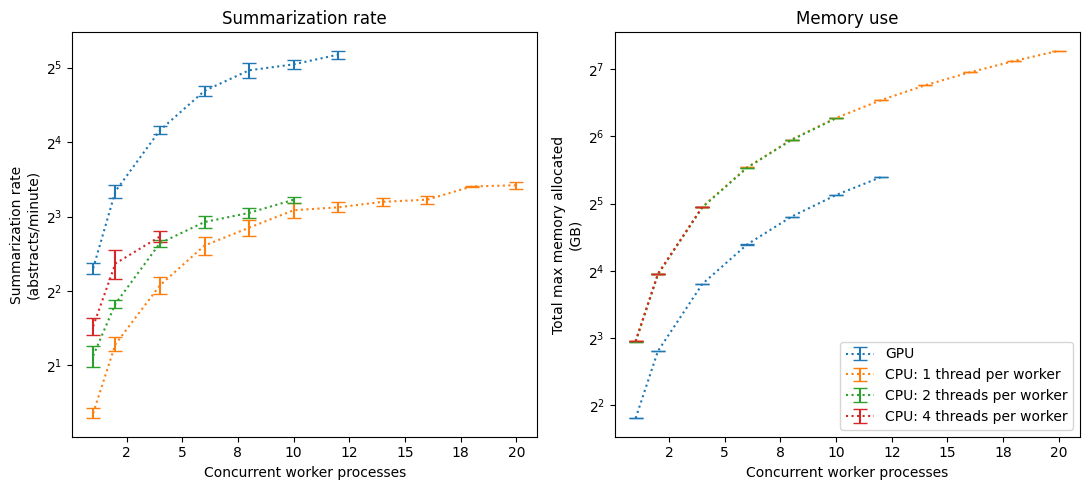

,abstracts,abstracts per worker,replicate,batches,device,workers,summarization time (sec.),summarization rate (abstracts/sec.),max memory allocated (bytes),model memory footprint (bytes),summarization rate (abstracts/min.),max memory allocated (GB),model memory footprint (GB)
0,3,3,1,3,GPU,1,34.627742,0.086636,3516818432,3132600320,5.198144,3.516818,3.1326
1,3,3,2,3,GPU,1,37.260599,0.080514,3506594816,3132600320,4.830840,3.506595,3.1326
2,3,3,3,3,GPU,1,36.094168,0.083116,3503448576,3132600320,4.986955,3.503449,3.1326
3,3,3,4,3,GPU,1,39.574945,0.075806,3520357376,3132600320,4.548332,3.520357,3.1326
4,3,3,5,3,GPU,1,35.101142,0.085467,3507774464,3132600320,5.128038,3.507774,3.1326


In [4]:
data, plt = plot_funcs.parallel_summarization_plot('../benchmarks/parallel_summarization/results.csv')

plt.show()
data.head()

### 4. Model quantization

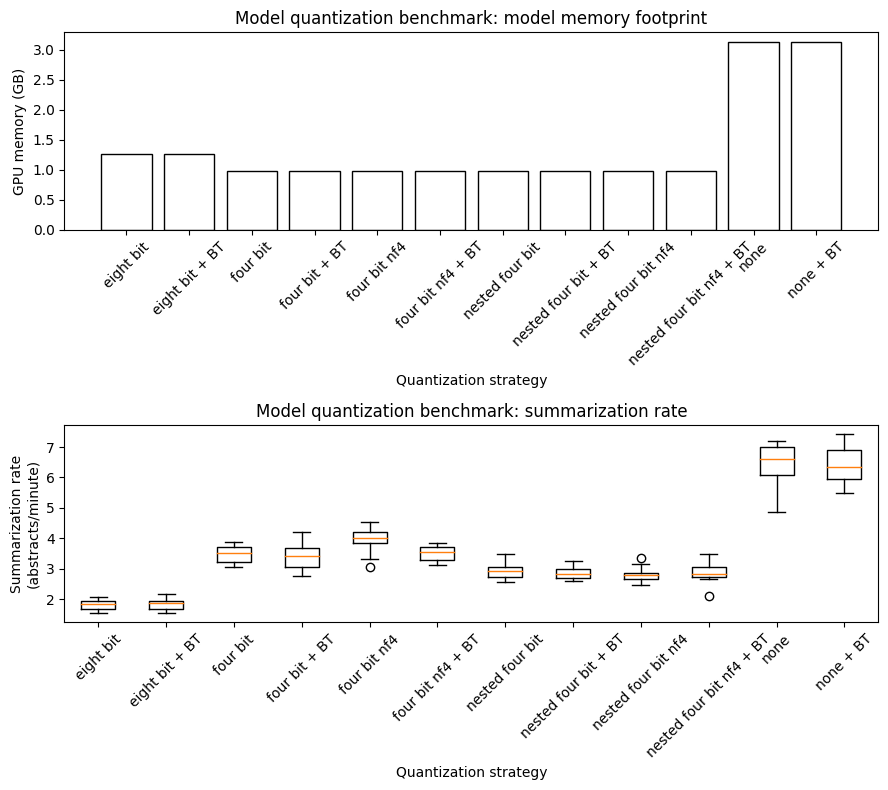

,replicate,abstracts,quantization strategy,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),model GPU memory footprint (GB)
0,1,5,none,61.830029,0.080867,3132600320,3529794560,4.852011,3.1326
1,2,5,none,42.642623,0.117254,3132600320,3504366080,7.035214,3.1326
2,3,5,none,46.971549,0.106447,3132600320,3521668096,6.386845,3.1326
3,4,5,none,54.685516,0.091432,3132600320,3529925632,5.485913,3.1326
4,5,5,none,50.119571,0.099761,3132600320,3507119104,5.985686,3.1326


In [5]:
data, plt = plot_funcs.model_quantization_plot('../benchmarks/model_quantization/results.csv')

plt.show()
data.head()

### 5. Batched summarization

Rate axis limits: 2, 25


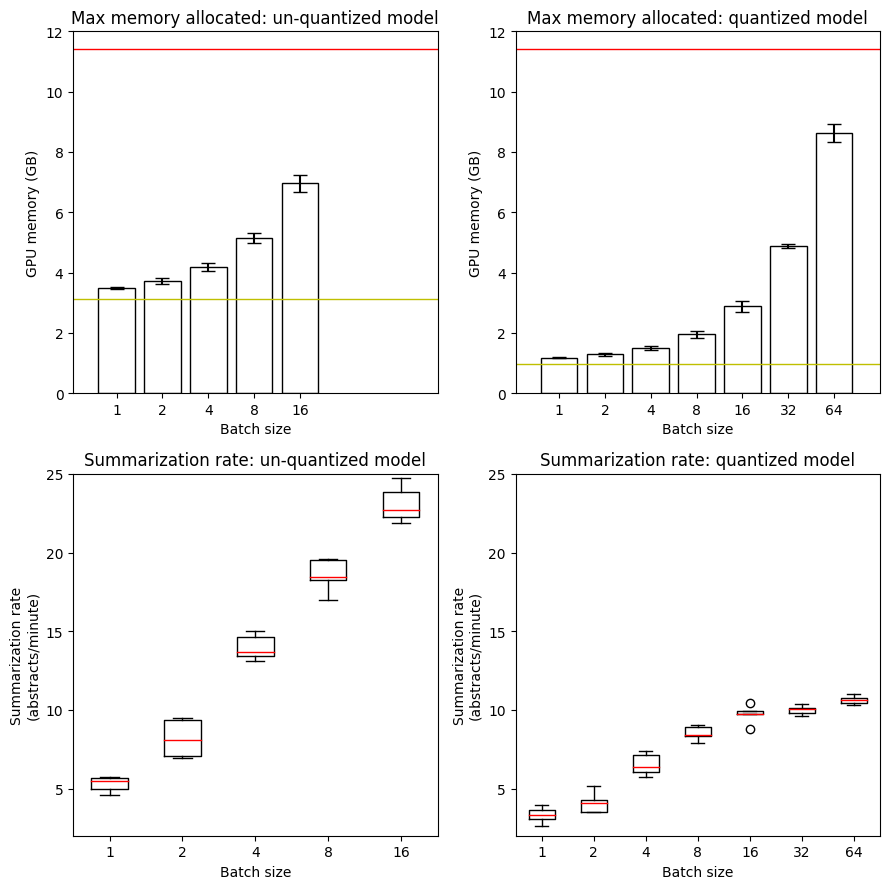

,abstracts,replicate,batches,batch size,quantization,summarization time (sec.),summarization rate (abstracts/sec.),model memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),max memory allocated (GB)
0,3,1,3,1,none,31.231767,0.096056,3132600320,3486147072,5.763363,3.486147
1,3,2,3,1,none,36.369606,0.082486,3132600320,3495322112,4.949187,3.495322
2,3,3,3,1,none,32.947045,0.091055,3132600320,3507513344,5.463312,3.507513
3,3,4,3,1,none,31.640228,0.094816,3132600320,3491390976,5.688960,3.491391
4,3,5,3,1,none,39.483424,0.075981,3132600320,3499255296,4.558875,3.499255


In [6]:
data, plt = plot_funcs.batch_summarization_plot(
    datafile='../benchmarks/batched_summarization/results.1.csv',
    unique_condition_columns=[
        'batch size',
        'quantization'
    ],
    oom_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    str_columns=['quantization'], 
    int_columns=[
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    float_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)'
    ],
    oom_replacement_val=np.nan
)

plt.show()
data.head()

Rate axis limits: 10, 28


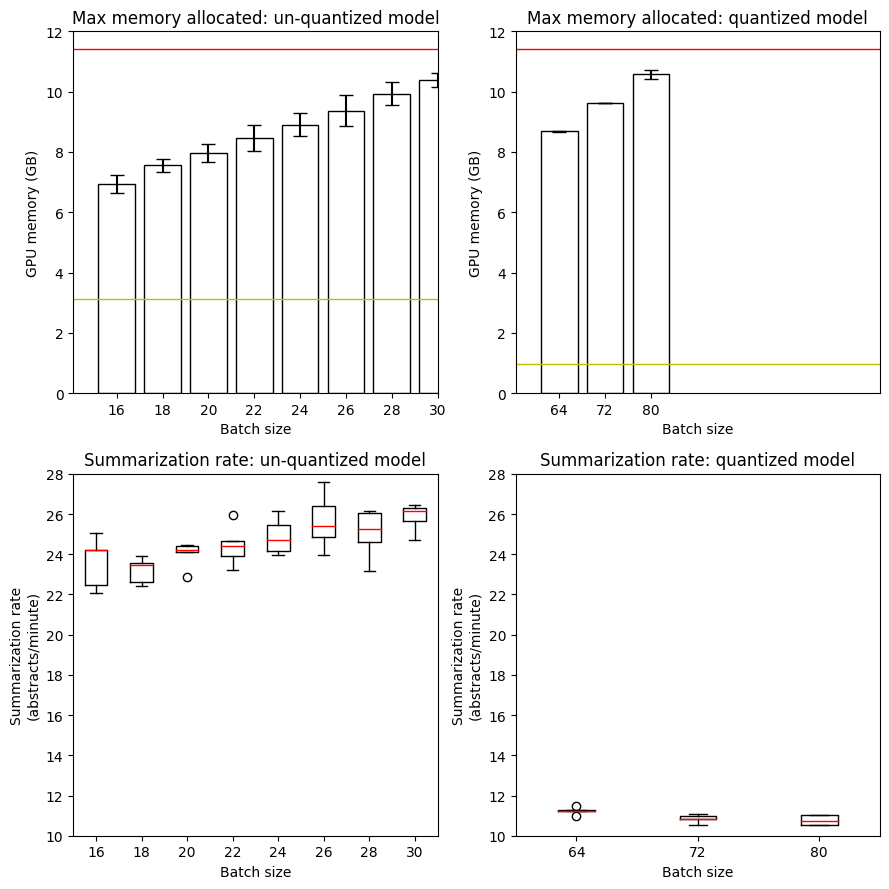

,abstracts,replicate,batches,batch size,quantization,summarization time (sec.),summarization rate (abstracts/sec.),model memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),max memory allocated (GB)
0,48,1,3,16,none,128.108073,0.374684,3132600320,6942313472,22.481019,6.942313
1,48,2,3,16,none,118.860944,0.403833,3132600320,6830813696,24.229994,6.830814
2,48,3,3,16,none,118.855940,0.403850,3132600320,6882015744,24.231014,6.882016
3,48,4,3,16,none,130.545901,0.367687,3132600320,7105768448,22.061206,7.105768
4,48,5,3,16,none,114.853584,0.417923,3132600320,6914101248,25.075404,6.914101
5,54,1,3,18,none,135.530981,0.398433,3132600320,7620695040,23.905973,7.620695
6,54,2,3,18,none,137.490580,0.392754,3132600320,7472815616,23.565251,7.472816
7,54,3,3,18,none,144.513304,0.373668,3132600320,7620695040,22.420081,7.620695
8,54,4,3,18,none,143.157580,0.377207,3132600320,7498778112,22.632403,7.498778
9,54,5,3,18,none,137.952217,0.391440,3132600320,7597888512,23.486393,7.597889


In [7]:
data, plt = plot_funcs.batch_summarization_plot(
    datafile='../benchmarks/batched_summarization/results.csv',
    unique_condition_columns=[
        'batch size',
        'quantization'
    ],
    oom_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    str_columns=['quantization'], 
    int_columns=[
        'model memory footprint (bytes)',
        'max memory allocated (bytes)'
    ], 
    float_columns=[
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)'
    ],
    oom_replacement_val=np.nan
)

plt.show()
data

### 5. Parallel batched summarization

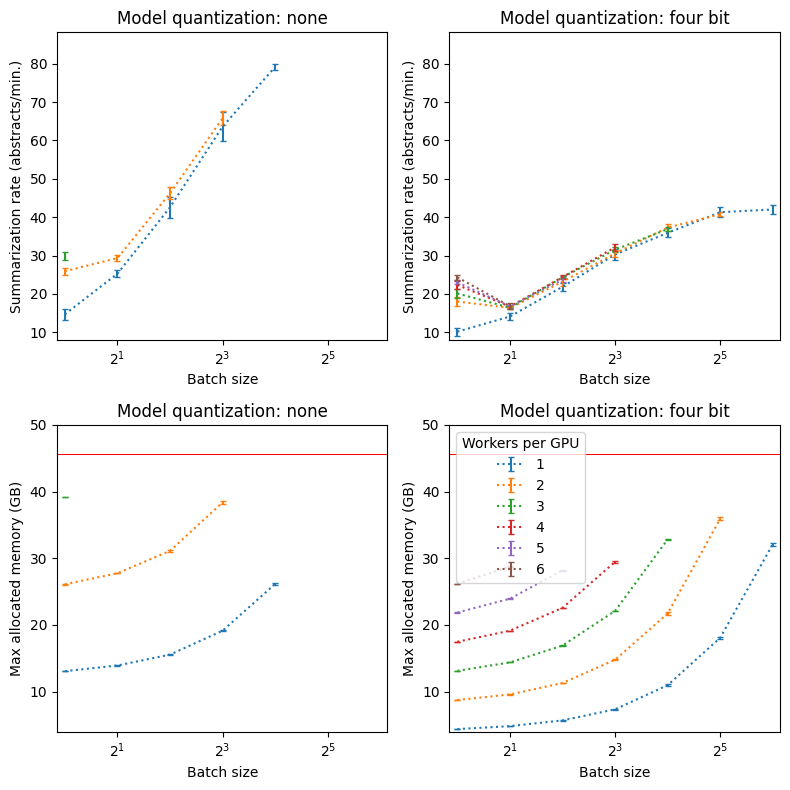

,abstracts,batches,replicate,batch size,workers,workers per GPU,quantization,summarization time (sec.),summarization rate (abstracts/sec.),max memory allocated (bytes),model memory footprint (bytes),summarization rate (abstracts/min.),max memory allocated (GB),model memory footprint (GB),jobs per GPU
0,3,3,1,1,4,1,none,43.645053,0.274945,1.397487e+10,1.253040e+10,16.496715,13.015108,11.669846,1
1,3,3,2,1,4,1,none,49.038482,0.244706,1.398942e+10,1.253040e+10,14.682347,13.028658,11.669846,1
2,3,3,3,1,4,1,none,46.499049,0.258070,1.403739e+10,1.253040e+10,15.484188,13.073337,11.669846,1
3,3,3,4,1,4,1,none,55.170995,0.217506,1.404486e+10,1.253040e+10,13.050336,13.080295,11.669846,1
4,3,3,5,1,4,1,none,52.396182,0.229024,1.401419e+10,1.253040e+10,13.741459,13.051730,11.669846,1


In [8]:
data, plt = plot_funcs.parallel_batched_summarization_plot('../benchmarks/parallel_batched_summarization/results.csv')

plt.show()
data.head()

### 6. SQL Insert

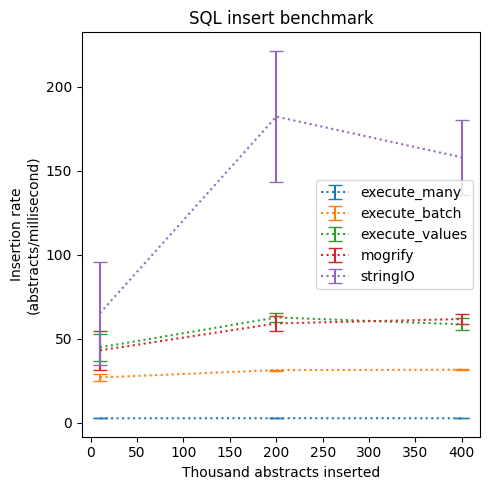

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond),thousand abstracts
0,10000,3.724415,2684.985381,execute_many,1,2.684985,10.0
1,10000,3.774634,2649.263727,execute_many,2,2.649264,10.0
2,10000,3.775181,2648.879578,execute_many,3,2.648880,10.0
3,200000,75.498859,2649.046659,execute_many,1,2.649047,200.0
4,200000,75.734771,2640.794947,execute_many,2,2.640795,200.0


In [9]:
data, plt = plot_funcs.sql_insert_plot('../benchmarks/sql_insert/results.csv')

plt.show()
data.head()

In [10]:
total_secs = 3580000 * 15
total_mins = total_secs / 60
total_hrs = total_mins / 60
total_unoptimized_days = total_hrs / 24
print(f'Estimated total summarization time, before optimization: {round(total_unoptimized_days, 0)} days.')

total_mins = 3580000 * (1/80)
total_hrs = total_mins / 60
total_optimized_days = total_hrs / 24
print(f'Estimated total summarization time, after optimization: {round(total_optimized_days, 0)} days.')

print(f'\nTotal speed-up: {round(total_unoptimized_days / total_optimized_days, 0)} fold.')

Estimated total summarization time, before optimization: 622.0 days.
Estimated total summarization time, after optimization: 31.0 days.

Total speed-up: 20.0 fold.
